<a href="https://colab.research.google.com/github/RonBartov/American_Sign_Language_Classification/blob/main/Copy_of_Deep_Learning_Final_Project_ASL_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Final Project- American Sign Language Images Classification**

In [142]:
import os
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image as Im 
from PIL import ImageOps
from google.colab import drive
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision.utils import make_grid
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Additional Functions That Will Be Used In The Project**

In [206]:
def plot_one_iPhone_img(indicator=None, img_source=None, int_to_letter_dict = None):
  ''' Inputs:
      indicator: the letter of the label.
      img_source: path of the iPhone images folder
      int_to_letter_dict: dictionary that maps int (label's number) to their corresponding letters {int: leter}

      Output:
      3 images plots- original image, gray scale and resized grayscale
  '''
  
  img_name = "ASL_iPhone_Image_" + indicator
  print("Image Name: " + img_name + "\n")
  img_path = img_source + "/ASL_Image_" + indicator + ".jpeg"
  img_rgb = Im.open(img_path)
  img_gray = ImageOps.grayscale(img_rgb)
  resized_gray_img = img_gray.resize((28, 28))

  print("Size of the original image:", np.array(img_rgb).shape)
  print("Size of the gray image:", np.array(img_gray).shape)
  print("Size of the gray resized image:", np.array(resized_gray_img).shape)

  # Plots
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].imshow(img_rgb)
  axs[0].set_title("Original Image")
  axs[1].imshow(img_gray, cmap='gray')
  axs[1].set_title("Gray Image")
  axs[2].imshow(resized_gray_img, cmap='gray')
  axs[2].set_title("Gray Resized Image")

  return None

In [5]:
def bar_graph_plot(pd_series, x_label='',y_label='',Title=''):
  '''
  Inputs:
  pd_series: pandas series of shape(N,). The names of the columns need to be an integers
  '''
  mean = pd_series.values.mean()
  plt.bar(pd_series.index, pd_series.values)
  plt.xticks(pd_series.index + 0.5, pd_series.index)
  plt.axhline(y=mean, color='red', linestyle='--')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(Title)
  
  # add average value to plot
  plt.annotate("Average: {:.6f}".format(mean), xy=(0, mean), xycoords='data',
              xytext=(0.3, 0.85), textcoords='figure fraction',
              arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2", color='black'),
              ha='center', va='bottom')
  plt.show()
  return None

In [172]:
def process_images(imgs_path,letter_to_int_dict):
  '''
  Inputs: 
  imgs_path: path that contains .jpeg images
  letter_to_int_dict, a dictionary that maps between the chars A-Z into their corresponding int 0-25
  '''
  
  data = []
  for file in os.listdir(imgs_path):
      if file.endswith(".jpeg"):
          label_char = file[len("ASL_Image_"):-len(".jpeg")]
          label_num = letter_to_int_dict[label_char]
          img = cv2.imread(os.path.join(imgs_path, file))
          resized_gray_img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (28, 28), interpolation=cv2.INTER_AREA)
          flat_img = resized_gray_img.reshape(-1)
          flat_img = np.append(label_num, flat_img)
          data.append(flat_img)
  data = np.array(data)
  df = pd.DataFrame(data=data, columns=["label"] + [f"pixel{i+1}" for i in range(784)])
  df["label"] = df["label"].astype(int)
  return df

In [202]:
def plot_images(dataframe, int_to_letter_dict):
    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    axs = axs.ravel()
    
    # create x and y limits
    jump = 4
    limits = [i for i in range(0, 28+jump, jump)]

    for i, row in dataframe.head(6).iterrows():
        ax = axs[i]
        ax.imshow(row[1:].values.reshape(28, 28), cmap='gray')
        ax.set_title("ASL_Image_" + int_to_letter_dict[row[0]])
        ax.axis('on')
        ax.set_xticks(limits)
        ax.set_yticks(limits[::-1])
        ax.grid(visible=True)
        ax.set_aspect('equal')  

    plt.tight_layout() # adjusts the spacing between subplots and the surrounding borders
    plt.show()

# **General Background and Goals**

Sign languages are visual languages that use hand gestures, facial expressions, and body language to convey some meaning. They are used as a means of communication by deaf and hard-of-hearing individuals in many countries around the world. Unlike spoken languages, sign languages are not based on a particular spoken language and are unique to the deaf communities in which they are used.

Despite the widespread use of sign languages, there is still much work to be done in improving communication between deaf and hearing individuals and the development of technologies that can recognize and understand sign languages is an important step towards this goal. 

**In our project**, we are exploring the use of deep learning for American Sign Language (ASL) recognition by teaching our neural network to classify between different ASL letters. The dataset we are using is the ASL MNIST dataset, which is a dataset that has been adapted to specifically focus on the recognition of American Sign Language.


###**Data Description**
Our data composed from 28x28 grayscale images (one channel images), each one represents one of the 24 american letters that **not require any motion**, i.e all the american letters except J and Z.



The data contains 34,627 images in total and it devided into the following types:

1) Test and Validation data- 27,455 images

2) Test Data- 7,172 images


In addition, the first column of the data represents the labels of the images as a numeric values. We have in total 26 american letters that their labels are the numbers 0-25 correspondingly to the order of the letters, and because we are not using the letters J and Z (which require motion as we mentioned before) we have left only with the labels 0-8 and 10-24.


###**Additional Goal**

In addition to the classification of the MNIST data itself, our goal in this project is to be able to classify letter from an image that was taken from our personal phones. This image will have a different properties, due to the type of the camera, initial resolution and also the enviroment where the image were taken, thus we will expect to get lower accuracy for those king of images.


###**Using 'Notes'** 
In orded to give some clear explenations regarding specific actions or decision we make, we will add a text box with a 'Note' title everytime we will finish such an action. 


Below you can see one example for an image that was taken with iPhone. The image initial rezolution is 2048x2048 and its type is RGB.

#**Initial Preparation for Our Personal Photos**

In order to be able to work also with our personal photos, we first would like to transfer it from it's current shape (folders of ".jpeg" photos) into a dataframe so it will be much easier to understand and analyze it. 

For that aim, we will create two dictionaries that we wil be use during this project:

1) letter_to_int_dict- maps the chars A-Z into the integers 0-24 correspondingly

2) int_to_letter_dict- maps the integers 0-24 into the chars A-Z

The transformation from images-folder structure into data frame will be implemented by using our 'process_images' function (you can read its description above

In [173]:
# creating the dictionaries
letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
integers = range(26)
int_to_letter_dict = dict(zip(integers,letters))
letter_to_int_dict = dict(zip(letters,integers))

In [205]:
# transforming images into dataframe

# Ron's path
iPhone_imgs_folder_path = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning Final Project- ASL/ASL_Images_From_Iphone"

# Aviv's path
# imgs_folder_path = ""

iPhone_imgs_df = process_images(iPhone_imgs_folder_path, letter_to_int_dict)
iPhone_imgs_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,5,207,208,208,208,208,210,210,211,212,...,125,179,189,187,185,185,183,182,183,184
1,2,206,207,207,207,208,208,210,211,212,...,188,185,183,182,180,180,179,179,180,181
2,1,216,216,216,217,217,218,218,220,221,...,90,148,186,185,181,180,178,178,178,180
3,0,213,213,212,212,212,213,213,213,214,...,87,82,97,144,181,190,187,186,185,185
4,24,202,203,204,204,205,205,205,205,205,...,96,93,86,71,122,173,172,172,171,167


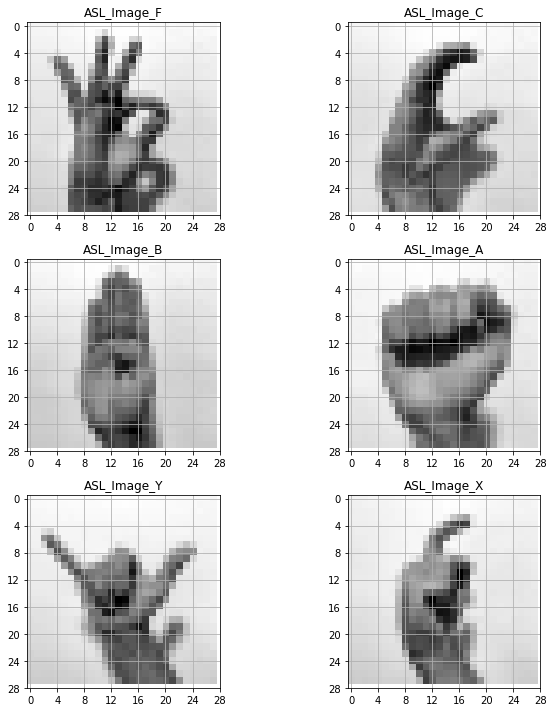

In [203]:
# plot iPhone photoes as an example
plot_images(iPhone_imgs_df.iloc[0:6], int_to_letter_dict)

Image Name: ASL_iPhone_Image_A

Size of the original image: (2048, 2048, 3)
Size of the gray image: (2048, 2048)
Size of the gray resized image: (28, 28)


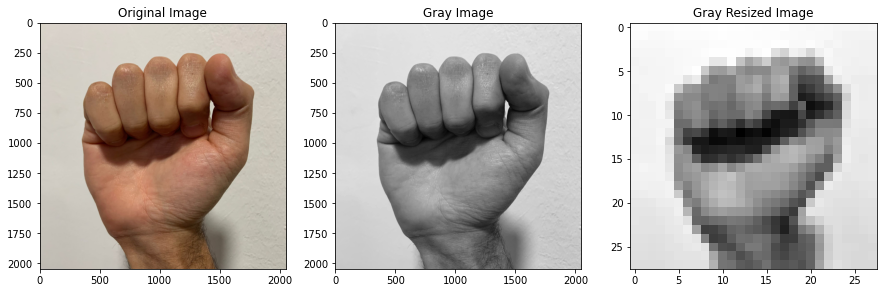

In [207]:
# plot one iPhone image to see the full process
plot_one_iPhone_img(indicator='A', img_source=iPhone_imgs_folder_path, int_to_letter_dict = int_to_letter_dict)

#**Importing the MNIST Data and Learning its Properties**

In order to start our training part properly, we would like to learn the data in the best way we can and to work with it in a right way according to its properties. That includes the following:

**1) High-level understanding of the data-** Checking the number of samples, classes, and the distribution of the data, such as the range of pixels values, mean and variance. In addition, we will also check wether there are missing values in the data cells.


**2) Splitting the data-** The ASL MNIST data already splitted into "train" and "test" sets, thus we will focus on splitting the "train" data into "train" and "validation" sets while trying not to change its distribution properties.

**3) Preprocessing-** Includes normalizing the data, removing missing values, and transforming the data so that it has the correct format for our model.

In [30]:
# Define the data paths

# Ron's paths
csv_train_val_path = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning Final Project- ASL/sign_mnist_train.zip"
csv_test_path = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning Final Project- ASL/sign_mnist_test.zip"

# Aviv's paths
# csv_train_val_path = "/content/gdrive/MyDrive/DP_course/final/data/sign_mnist_train.csv"
# csv_test_path = "/content/gdrive/MyDrive/DP_course/final/data/sign_mnist_test.csv"


In [31]:
df_train_val = pd.read_csv(csv_train_val_path)
df_test = pd.read_csv(csv_test_path)

In [32]:
# presenting few rows from the train dataframe 
df_train_val.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### **Note #1**

As we see above, each row in the data represents an image. The first column is the label value and the rest are the pixels values. Because the images are of size 28x28, then we have 784 pixels values in total.

## **1) High-level understanding of the data before splitting**

In [33]:
# data shape
print('Shape the unified training and validation set: ', df_train_val.shape)
print('Shape of samples in the test set: ', df_test.shape)

Shape the unified training and validation set:  (27455, 785)
Shape of samples in the test set:  (7172, 785)


In [34]:
# check for maximum and minimum pixels values and verify there is no missing values in the data 
print("Missing values in the unified training and validation set: ", df_train_val.isnull().sum().sum())
print("Missing values in the test set: ", df_test.isnull().sum().sum(), "\n")
print("Maximum pixel value in unified training and validation set: ", df_train_val.iloc[:,1:].max().max())
print("Minimum pixel value in unified training and validation set: ", df_train_val.iloc[:,1:].min().min())

Missing values in the unified training and validation set:  0
Missing values in the test set:  0 

Maximum pixel value in unified training and validation set:  255
Minimum pixel value in unified training and validation set:  0


In [35]:
# calculate the appearence percentage for each label in the unified training and validation set
count_label = df_train_val.groupby('label').size() 
count_label_percentage = count_label/len(df_train_val.axes[0])
count_label_percentage

label
0     0.041013
1     0.036787
2     0.041668
3     0.043562
4     0.034857
5     0.043854
6     0.039701
7     0.036897
8     0.042324
10    0.040575
11    0.045201
12    0.038427
13    0.041923
14    0.043562
15    0.039628
16    0.046585
17    0.047132
18    0.043671
19    0.043198
20    0.042287
21    0.039410
22    0.044618
23    0.042397
24    0.040721
dtype: float64

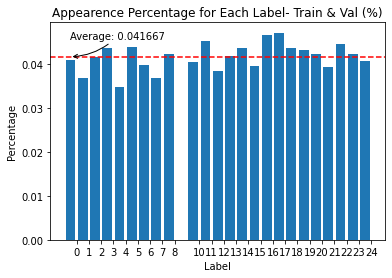

In [37]:
# presenting appearence percentage for each label in a bar plot
bar_graph_plot(count_label_percentage, x_label='Label',y_label='Percentage',Title='Appearence Percentage for Each Label- Train & Val (%)')

In [36]:
# calculate the distance from the average number of images per label (in terms of percentage)
label_avg_count = count_label.sum()//24
print("Average number of samples per label is: ", label_avg_count)
label_diffrence_from_avg = abs(count_label - label_avg_count)/label_avg_count
label_diffrence_from_avg

Average number of samples per label is:  1143


label
0     0.014873
1     0.116360
2     0.000875
3     0.046369
4     0.162730
5     0.053368
6     0.046369
7     0.113736
8     0.016623
10    0.025372
11    0.085739
12    0.076990
13    0.006999
14    0.046369
15    0.048119
16    0.118985
17    0.132108
18    0.048994
19    0.037620
20    0.015748
21    0.053368
22    0.071741
23    0.018373
24    0.021872
dtype: float64

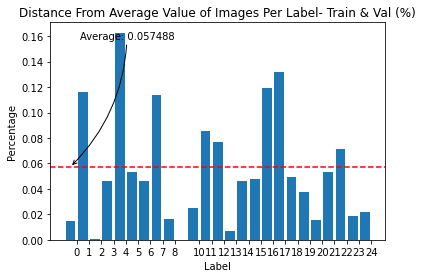

In [38]:
# presenting distance from the average number of images per label in a bar plot
bar_graph_plot(label_diffrence_from_avg, x_label='Label',y_label='Percentage',Title='Distance From Average Value of Images Per Label- Train & Val (%)')

In [39]:
# calculate expectation probability distribution properties
mean_train_and_val = df_train_val.iloc[:,1:].mean(axis=0) # size (784,)
var_train_and_val = df_train_val.iloc[:,1:].var(axis=0) # size (784,)
print("For each pixel in df_train_val, the mean is around: ", mean_train_and_val.mean())
print("For each pixel in df_train_val, the variance is around: ", var_train_and_val.mean())

For each pixel in df_train_val, the mean is around:  159.2910081989452
For each pixel in df_train_val, the variance is around:  2181.1783633275427


## **2) Splitting the data and recheck its distribution**

In [62]:
# Split the training data into train and validation sets
val_train_factor = 0.2 # df_val_size = val_train_factor*df_train_size
df_train, df_val = train_test_split(df_train_val, test_size=val_train_factor, random_state=42)

# reset indexes
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

print('Shape of the unified training and validation set: ', df_train_val.shape)
print('Shape of the training set: ', df_train.shape)
print('Shape of the validation set: ', df_val.shape)

df_train.head()

Shape of the unified training and validation set:  (27455, 785)
Shape of the training set:  (21964, 785)
Shape of the validation set:  (5491, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,10,97,65,128,44,17,67,64,66,69,...,189,180,134,97,76,86,94,90,91,91
1,15,215,216,217,223,206,176,176,191,106,...,133,133,132,132,134,124,167,124,23,140
2,0,144,145,146,147,150,150,151,151,151,...,78,107,183,187,171,160,131,134,101,72
3,10,64,73,83,96,101,108,111,115,118,...,163,167,169,169,170,173,173,175,175,176
4,22,83,88,57,75,101,37,17,63,69,...,87,71,52,95,183,176,180,182,184,186


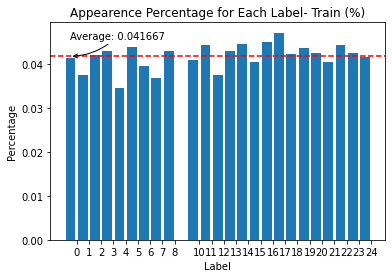

In [44]:
# calculate the appearence percentage for each label in the training set
count_label_train = df_train.groupby('label').size() 
count_label_percentage_train = count_label_train/len(df_train.axes[0])
count_label_percentage_train

bar_graph_plot(count_label_percentage_train, x_label='Label',y_label='Percentage',Title='Appearence Percentage for Each Label- Train (%)')

Average number of samples per label is:  915


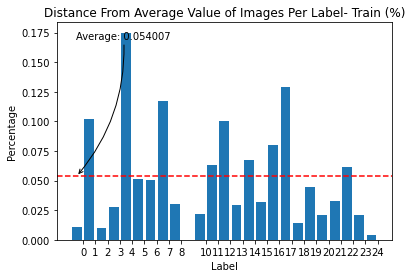

In [45]:
# calculate the distance from the average number of images per label (in terms of percentage)
label_avg_count_train = count_label_train.sum()//24
label_diffrence_from_avg_train = abs(count_label_train - label_avg_count_train)/label_avg_count_train
label_diffrence_from_avg_train

print("Average number of samples per label is: ", label_avg_count_train)
bar_graph_plot(label_diffrence_from_avg_train, x_label='Label',y_label='Percentage',Title='Distance From Average Value of Images Per Label- Train (%)')

In [ ]:
# y_train = df_train['label']
# y_test = df_test['label']
# del df_train['label']
# del df_test['label']
# x_train = df_train.values
# x_test = df_test.values
# x_train = x_train / 255
# x_test = x_test / 255
# x_train = x_train.reshape(-1,28,28,1)
# x_test = x_test.reshape(-1,28,28,1)
# x_test_tensor = torch.Tensor(x_test).swapaxes(1, 3).swapaxes(2 , 3)
# x_train_tensor = torch.Tensor(x_train).swapaxes(1, 3).swapaxes(2 , 3)

In [59]:
# print(x_test.shape)
# print(x_test_tensor.shape)

In [ ]:
# norm_mean = 0.5 
# norm_std = 0.5 
# output_size = 24      # there are 10 classes
# train_loader = torch.utils.data.DataLoader(df_train, batch_size=500, shuffle=True , transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((norm_mean,), (norm_std,))
#                    ]))
# test_loader = torch.utils.data.DataLoader(df_test, batch_size=500, shuffle=True)
# print(train_loader.dataset.__len__())
# print(test_loader.dataset.__len__())

## **Creating the neural network for the classification**

Consider ResNet and VGG

In [51]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=75, kernel_size=(3, 3), stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(75)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=75, out_channels=50, kernel_size=(3, 3), stride=1, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.batchnorm2 = nn.BatchNorm2d(50)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=25, kernel_size=(3, 3), stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(25)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1)
        
        self.fc1 = nn.Linear(25 * 4 * 4, 512)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 25)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.batchnorm2(x)
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pool3(x)

        x = x.view(-1, 25 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        
        return x

## **Creating the training function**

In [171]:
def test(model, test_loader, criterion):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct / total
        return accuracy

In [53]:
def data_loader(csv_data ,batch_size):
    # Convert the dataframe into a PyTorch tensor
    data = torch.tensor(csv_data.values, dtype=torch.float32)
    
    # Split the data into inputs (images) and targets (labels)
    inputs = data[:, 1:]
    targets = data[:, 0].long()
    
    # Normalize the inputs
    inputs = inputs / 255.0
    
    # Convert inputs into a 4D tensor for processing by the model
    inputs = inputs.view(-1, 1, 28, 28)
    
    # Create a TensorDataset from the inputs and targets
    dataset = TensorDataset(inputs, targets)
    
    # Create a DataLoader from the dataset
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [54]:
def train_model(train_data,val_data, model, criterion, optimizer, num_epochs = 500, batch_size= 500):
    model.train()

    # # Create a DataLoader from the dataset
    data_train = data_loader(train_data , batch_size)
    data_val = data_loader(val_data , batch_size)
    n = 0
    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]
    for epoch in range(num_epochs):

        for i, (images, labels) in enumerate(data_train):
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            #loss = criterion(outputs.cpu(), labels.cpu())
            loss = F.nll_loss(outputs.cpu(), labels.cpu())
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss
            n+=1
            if n%50 ==0:
              iters_sub.append(n)
              train_cost = float(loss.detach().numpy())
              data_train_2 = data_loader(train_data[1:2000] , batch_size)
              train_acc = test(model, data_train_2 , criterion)

              train_accs.append(train_acc)
              val_acc = test(model, data_val , criterion)
              val_accs.append(val_acc)
              print(f'Epoch [{epoch+1}/{num_epochs}] '+"Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
              n, val_acc * 100, train_acc * 100, train_cost))
              #print(f'Epoch [{epoch+1}/{num_epochs}] , Iteration[{n}], Loss: {loss.item()}')
            
    print('Finished Training')
    return iters, losses, iters_sub, train_accs, val_accs

##Train the model

In [55]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
from torchvision import models
from torchsummary import summary
summary(model.cuda(), (1,28,28))

input shape: torch.Size([2, 1, 28, 28])
second shape: torch.Size([2, 75, 14, 14])
3 shape: torch.Size([2, 50, 7, 7])
4 shape: torch.Size([2, 25, 4, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 75, 28, 28]             750
       BatchNorm2d-2           [-1, 75, 28, 28]             150
         MaxPool2d-3           [-1, 75, 14, 14]               0
            Conv2d-4           [-1, 50, 14, 14]          33,800
           Dropout-5           [-1, 50, 14, 14]               0
       BatchNorm2d-6           [-1, 50, 14, 14]             100
         MaxPool2d-7             [-1, 50, 7, 7]               0
            Conv2d-8             [-1, 25, 7, 7]          11,275
       BatchNorm2d-9             [-1, 25, 7, 7]              50
        MaxPool2d-10             [-1, 25, 4, 4]               0
           Linear-11                  [-1, 512]         205,312
          Dropo

In [56]:
model.to(device)
iters, losses, iters_sub, train_accs, val_accs = train_model(df_train,df_val, model, criterion, optimizer, num_epochs = 3, batch_size= 128)


Epoch [1/3] Iter 50. [Val Acc 81%] [Train Acc 81%, Loss 0.418508]
Epoch [1/3] Iter 100. [Val Acc 98%] [Train Acc 98%, Loss 0.112319]
Epoch [1/3] Iter 150. [Val Acc 100%] [Train Acc 100%, Loss 0.008116]
Epoch [2/3] Iter 200. [Val Acc 100%] [Train Acc 100%, Loss 0.002498]
Epoch [2/3] Iter 250. [Val Acc 100%] [Train Acc 100%, Loss 0.000581]
Epoch [2/3] Iter 300. [Val Acc 100%] [Train Acc 100%, Loss 0.000738]
Epoch [3/3] Iter 350. [Val Acc 100%] [Train Acc 100%, Loss 0.000450]
Epoch [3/3] Iter 400. [Val Acc 100%] [Train Acc 100%, Loss 0.000317]
Epoch [3/3] Iter 450. [Val Acc 100%] [Train Acc 100%, Loss 0.000182]
Epoch [3/3] Iter 500. [Val Acc 100%] [Train Acc 100%, Loss 0.000275]
Finished Training


In [113]:
def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs*100, label="Train")
    plt.plot(iters_sub, val_accs*100, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

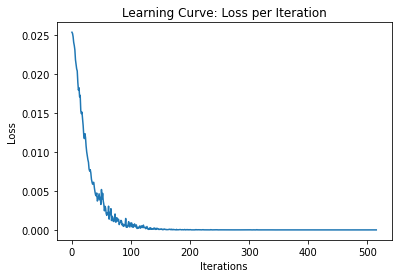

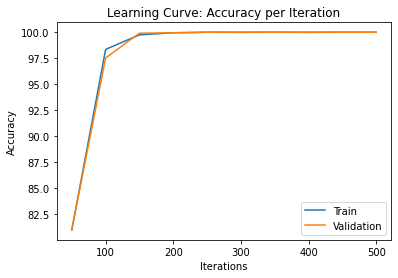

In [114]:
val_accs = np.array(val_accs)
train_accs = np.array(train_accs)
plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs)

In [176]:
test_loader1 = data_loader(iPhone_imgs_df , 15)
test1 = test(model, test_loader1, criterion)
print(test1)

0.4166666666666667


In [118]:
test_loader = data_loader(df_test , 120)

In [ ]:
##lets see some results

In [119]:
xxxxx = test(model, test_loader, criterion)
print(xxxxx)

0.9523145566090352


In [ ]:
#torch.save(model, "/content/gdrive/MyDrive/DP_course/final/data/model1.pk.")